In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from scipy.spatial import distance_matrix as distanceMatrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
# Import hierarchical clustering libraries
from scipy.cluster.hierarchy import dendrogram, linkage
# import agglomerative clustering
from sklearn.cluster import AgglomerativeClustering


In [2]:
def loadData(path):
    data = pd.read_csv(path)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return x, y

def splitData(x, y, train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0, stratify=y)
    return x_train, x_test, y_train, y_test

def preprocessData(x):
    
    ct = ColumnTransformer( [('one_hot_encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough' )
    ct = ct.fit(x)
    x = pd.DataFrame(ct.transform(x))

    # Scaling the data since the features are in different scales
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x))

    return x

### Hierarchical Clustering (Agglomerative Clustering not Divisive)

In [3]:
def constructDistanceMatrix(data):
    distance_matrix = distanceMatrix(data, data)
    distance_matrix = (distance_matrix + distance_matrix.T)/2
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix

def linkage(distance_matrix, clusters, cluster1, cluster2, linkage):
    if linkage == 'single': # Minimum distance between two clusters
        min_distance = np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] < min_distance:
                    min_distance = distance_matrix[i,j]
        return min_distance
    elif linkage == 'complete': # Maximum distance between two clusters
        max_distance = -np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] > max_distance:
                    max_distance = distance_matrix[i,j]
        return max_distance
    elif linkage == 'average' or linkage == 'mean': # Average distance between two clusters
        sum_distance = 0
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                sum_distance += distance_matrix[i,j]
        return sum_distance/(len(clusters[cluster2]) * len(clusters[cluster1]))
    else:
        raise ValueError('Invalid linkage type')
    
def hierarchical_clustering(data, linkage_type, n_clusters, y):
    # Marking each data point as a cluster
    clusters = [[i] for i in range(len(data))]

    # Calculating the distance matrix using Euclidean distance (default of distanceMatrix function)
    distance_matrix = constructDistanceMatrix(data)
    
    # Iteratively merging the clusters
    while len(clusters) > n_clusters:

        # Finding closest two clusters
        min_distance = np.inf
        min_i,min_j = -1,-1
        for i in range(len(clusters)):
            for j in range(i+1,len(clusters)):
                dist = distance_matrix[i,j]
                if dist < min_distance:
                    min_distance = dist
                    min_i,min_j = i,j

        # Merging the closest two clusters
        clusters[min_i] = clusters[min_i] + clusters[min_j]

        # Removing the second cluster
        clusters.pop(min_j)
        
        # Adjusting the distance matrix 
        for i in range(len(clusters)):
            if i == min_i: continue
            distance_matrix[min_i,i] = distance_matrix[i,min_i] = linkage(distance_matrix, clusters, i, min_i, linkage_type)
    
    # Using the majority voting to get the cluster labels 
    indexToLabel = {}
    for i in range(len(clusters)):
        labels = []
        for j in clusters[i]:
            labels.append(y[j])
        indexToLabel[i] = max(set(labels), key=labels.count)
        

    predicted = []
    for i in range(len(data)):
        for j in range(len(clusters)):
            if i in clusters[j]:
                predicted.append(indexToLabel[j])
                break
    return clusters, predicted


# Evaluating hierarchical clustering

In [ ]:
# Loading the data
x, y = loadData('archive/kddcup.data.corrected')

# Preprocessing the data
x = preprocessData(x)
print("The shape of the training data is: ", x.shape)

# Splitting the data into train and test
x_train, x_test, y_train, y_test = splitData(x, y, train_size=0.00025)

In [ ]:
# Save the x_train and y_train as numpy arrays
np.save('hierarchicalClustering-Preprocessed/x_train.npy', x_train)
np.save('hierarchicalClustering-Preprocessed/y_train.npy', y_train)

In [4]:
# Loading the preprocessed data as numpy arrays
x_train = np.load('hierarchicalClustering-Preprocessed/x_train.npy', allow_pickle=True)
y_train = np.load('hierarchicalClustering-Preprocessed/y_train.npy', allow_pickle=True)

In [10]:
# Applying hierarchical clustering
clusters, y_pred = hierarchical_clustering(x_train, 'complete', 55, y_train)

# Evaluating the model
print("Macro: ")
print("Precision: ", precision_score(y_train, y_pred, average='macro'))
print("Recall: ", recall_score(y_train, y_pred, average='macro'))
print("F1 score: ", f1_score(y_train, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print("Weighted: ")
print("Precision: ", precision_score(y_train, y_pred, average='weighted'))
print("Recall: ", recall_score(y_train, y_pred, average='weighted'))
print("F1 score: ", f1_score(y_train, y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print(classification_report(y_train, y_pred))

Macro: 
Precision:  0.2710596314166657
Recall:  0.27976097669298333
F1 score:  0.2740540247863729
Accuracy:  0.7099673202614379
--------------------------------------------------
Weighted: 
Precision:  0.7227927373421266
Recall:  0.7099673202614379
F1 score:  0.7137367963456297
Accuracy:  0.7099673202614379
--------------------------------------------------
              precision    recall  f1-score   support

    ipsweep.       0.00      0.00      0.00         3
    neptune.       0.52      0.66      0.58       268
       nmap.       0.00      0.00      0.00         1
     normal.       0.48      0.48      0.48       243
  portsweep.       0.00      0.00      0.00         3
      satan.       0.00      0.00      0.00         4
      smurf.       0.89      0.82      0.86       702

    accuracy                           0.71      1224
   macro avg       0.27      0.28      0.27      1224
weighted avg       0.72      0.71      0.71      1224



C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarnin

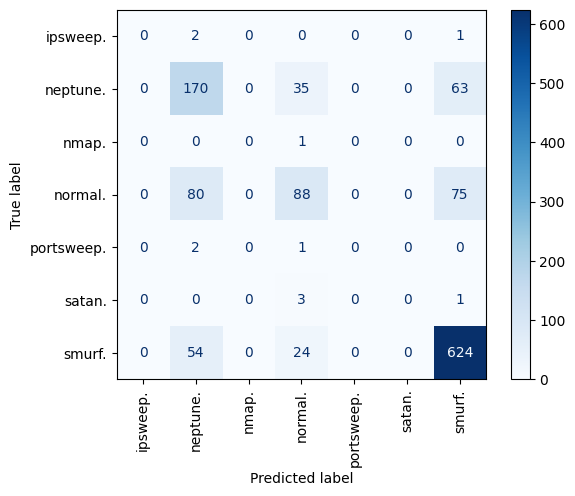

In [6]:
# Printing the confusion matrix
cm = confusion_matrix(y_train, y_pred)
# Displaying the confusion matrix in much bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()

In [8]:
clusterer = AgglomerativeClustering(n_clusters=45, affinity='euclidean', linkage='average')
clusterer.fit(x_train)

# Getting the labels of the points
labels = clusterer.labels_ 

# Create a list of clusters of size k
cluster = [[] for i in range(45)]

# Assign each point to its cluster
for i in range(len(labels)):
    cluster[labels[i]].append(i)

# Create array name clusterLabels to store the labels of the clusters based on the most frequent label in the cluster in y
clusterLabels = []
for i in range (len(cluster)):
    counterLabels = {}
    for j in range(len(cluster[i])):
        counterLabels[y_train[cluster[i][j]]] = counterLabels.get(y_train[cluster[i][j]], 0) + 1
    # Assign the most frequent label to the cluster
    maxLabel = max(counterLabels, key=counterLabels.get)
    clusterLabels.append(maxLabel)

pointsLabels = []
for i in range(len(labels)):
    pointsLabels.append(clusterLabels[labels[i]])

predicted = pointsLabels
# now evaluate the model using the predicted labels
print("Macro: ")
print("Precision: ", precision_score(y_train, predicted, average='macro'))
print("Recall: ", recall_score(y_train, predicted, average='macro'))
print("F1 score: ", f1_score(y_train, predicted, average='macro'))
print("Accuracy: ", accuracy_score(y_train, predicted))

print("-" * 50)

print("Weighted: ")
print("Precision: ", precision_score(y_train, predicted, average='weighted'))
print("Recall: ", recall_score(y_train, predicted, average='weighted'))
print("F1 score: ", f1_score(y_train, predicted, average='weighted'))
print("Accuracy: ", accuracy_score(y_train, predicted))

C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Macro: 
Precision:  0.798101481355355
Recall:  0.776601998824221
F1 score:  0.7679556291910173
Accuracy:  0.8872549019607843
--------------------------------------------------
Weighted: 
Precision:  0.9049188557027897
Recall:  0.8872549019607843
F1 score:  0.8699114546250933
Accuracy:  0.8872549019607843


C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yousef\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
